<a href="https://colab.research.google.com/github/albert-yue/gcn-explainability/blob/master/notebooks/experiment_sst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [43]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
%cd gdrive/My\ Drive/MIT/gcn_explainability/

[Errno 2] No such file or directory: 'gdrive/My Drive/MIT/gcn_explainability/'
/content/gdrive/My Drive/MIT/gcn_explainability


In [0]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/albert-yue/gcn-explanability
   a55323d..f954ed8  master     -> origin/master
Updating a55323d..f954ed8
Fast-forward
 src/treebank_train.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
from tqdm.auto import tqdm

from src.data import Treebank, SyntaxTree, GCNDataset, GCNInput
from src.models.gcn import GCN, GCNTreebankModel
from src.stanford_preprocessing import *
from src.train import accuracy
from src.treebank_train import train, evaluate

# Working out GloVe embeddings

In [0]:
embedding_map = stpp.load_glove_embeddings('data/glove.6B.200d.txt')

In [0]:
all_embeddings = torch.cat(list(embedding_map.values()), dim=0)

In [0]:
all_values = all_embeddings.flatten().detach().numpy()

mu, std = norm.fit(all_values)

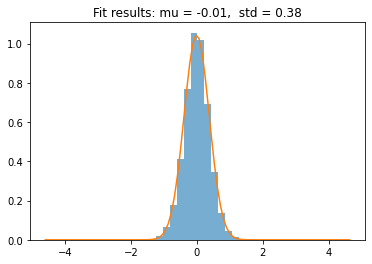

In [0]:
plt.hist(all_values, bins=40, density=True, alpha=0.6)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

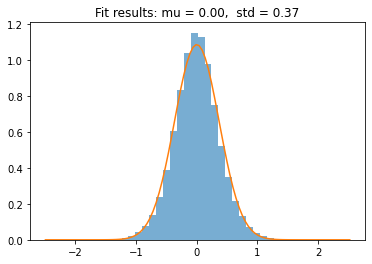

In [0]:
all_values_0 = all_embeddings[:, 0:1].flatten().detach().numpy()

mu, std = norm.fit(all_values_0)

plt.hist(all_values_0, bins=40, density=True, alpha=0.6)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [0]:
embed_dims = all_embeddings.size(1)

mus, stds = [], []

for i in range(embed_dims):
    all_dim_values = all_embeddings[:, i].detach().numpy()
    mu, std = norm.fit(all_dim_values)
    mus.append(mu)
    stds.append(std)

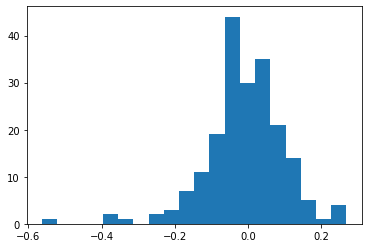

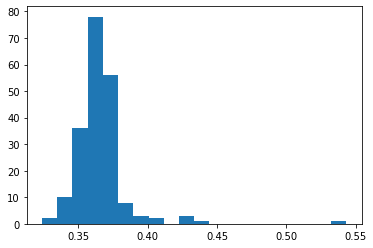

In [0]:
plt.hist(mus, bins=20)
plt.show()
plt.hist(stds, bins=20)
plt.show()

# Set up inputs and adjacency matrices

In [0]:
embedding_map = load_glove_embeddings('data/glove.6B.200d.txt')

In [0]:
trees = []
with open('data/stanford_sentiment_treebank/train.txt') as f:
    for line in tqdm(f.readlines()):
        tree = parse_tree(line)
        sentence = extract_tokens(tree)
        label = tree.label
        trees.append(SyntaxTree(sentence, tree, label))
train_treebank = Treebank(trees)

In [0]:
trees = []
with open('data/stanford_sentiment_treebank/dev.txt') as f:
    for line in tqdm(f.readlines()):
        tree = parse_tree(line)
        sentence = extract_tokens(tree)
        label = tree.label
        trees.append(SyntaxTree(sentence, tree, label))
dev_treebank = Treebank(trees)

In [0]:
trees = []
with open('data/stanford_sentiment_treebank/test.txt') as f:
    for line in tqdm(f.readlines()):
        tree = parse_tree(line)
        sentence = extract_tokens(tree)
        label = tree.label
        trees.append(SyntaxTree(sentence, tree, label))
test_treebank = Treebank(trees)

In [0]:
default_gen_func = lambda: generate_random_embedding(200, 0.0, 0.38)
orig_num = len(embedding_map)

In [0]:
inputs = []
for example in train_treebank:
    tree = example.tree
    adj, inp = extract_adj_matrix_and_input(tree, embedding_map, default_gen_func)
    inputs.append(GCNInput(adj, inp, example.label))

print('Number missing GloVe embedding:', len(embedding_map) - orig_num)

train_dataset = GCNDataset(inputs)

Number missing GloVe embedding: 1296


In [0]:
inputs = []
for example in dev_treebank:
    tree = example.tree
    adj, inp = extract_adj_matrix_and_input(tree, embedding_map, default_gen_func)
    inputs.append(GCNInput(adj, inp, example.label))

print('Number missing GloVe embedding:', len(embedding_map) - orig_num)

dev_dataset = GCNDataset(inputs)

Number missing GloVe embedding: 1476


In [0]:
inputs = []
for example in test_treebank:
    tree = example.tree
    adj, inp = extract_adj_matrix_and_input(tree, embedding_map, default_gen_func)
    inputs.append(GCNInput(adj, inp, example.label))

print('Number missing GloVe embedding:', len(embedding_map) - orig_num)

test_dataset = GCNDataset(inputs)

Number missing GloVe embedding: 1784


In [0]:
for dataset in [train_dataset, test_dataset, dev_dataset]:
    for inputs in dataset:
        adj = inputs.adj
        d = torch.diag(adj.sum(dim=1) ** (-1/2))
        inputs.adj = d@adj@d

In [0]:
all_train = {'treebank': train_treebank, 'inputs': train_dataset}
torch.save(all_train, 'data/stanford_sentiment_treebank/stanford_train.pt')

In [0]:
all_dev = {'treebank': dev_treebank, 'inputs': dev_dataset}
torch.save(all_dev, 'data/stanford_sentiment_treebank/stanford_dev.pt')

In [0]:
all_test = {'treebank': test_treebank, 'inputs': test_dataset}
torch.save(all_test, 'data/stanford_sentiment_treebank/stanford_test.pt')

In [0]:
torch.save(embedding_map, 'data/stanford_sentiment_treebank/embeddings.pt')

# m = torch.load('data/stanford_sentiment_treebank/embeddings.pt')

In [0]:
print(train_dataset.labels().unique())
print(dev_dataset.labels().unique())
print(test_dataset.labels().unique())

tensor([0., 1., 2., 3., 4.])
tensor([0., 1., 2., 3., 4.])
tensor([0., 1., 2., 3., 4.])


# Training

In [0]:
from matplotlib import pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.title("SST Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend(loc='lower left')

In [0]:
def load_dataset(data_path):
    full = torch.load(data_path)
    return full['treebank'], full['inputs']

train_treebank, train_dataset = load_dataset('data/stanford_sentiment_treebank/stanford_train.pt')
dev_treebank, dev_dataset = load_dataset('data/stanford_sentiment_treebank/stanford_dev.pt')
test_treebank, test_dataset = load_dataset('data/stanford_sentiment_treebank/stanford_test.pt')

In [0]:
embed_size = 200
hidden_size = 100  # hyperparameter
dropout = 0.1  # hyperparameter
epochs = 500
lr = 0.0001
batch_size = 50

model = GCNTreebankModel(embed_size, hidden_size, 5, dropout=dropout)

In [58]:
%time train_losses, val_losses = train(model, train_dataset, dev_dataset, early_stop_threshold=20, batch_size=batch_size, epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='sst_train.pt')

Epoch 0
Train mean cross-entropy: 1.613893830425599
Validation mean cross-entropy: 1.5477652549743652
Epoch 10
Train mean cross-entropy: 1.378191800327862
Validation mean cross-entropy: 1.402413010597229
Epoch 20
Train mean cross-entropy: 1.3137961983680726
Validation mean cross-entropy: 1.3969584703445435
Epoch 30
Train mean cross-entropy: 1.2726560268331977
Validation mean cross-entropy: 1.3868483304977417
Epoch 40
Train mean cross-entropy: 1.2556913310990614
Validation mean cross-entropy: 1.3869428634643555
Epoch 50
Train mean cross-entropy: 1.2821707707117587
Validation mean cross-entropy: 1.3838798999786377
Epoch 60
Train mean cross-entropy: 1.179952619882191
Validation mean cross-entropy: 1.3883792161941528
Epoch 70
Train mean cross-entropy: 1.2937014727908023
Validation mean cross-entropy: 1.3840088844299316
Epoch 80
Train mean cross-entropy: 1.240844252004343
Validation mean cross-entropy: 1.382205605506897
Epoch 90
Train mean cross-entropy: 1.179421330287176
Validation mean cr

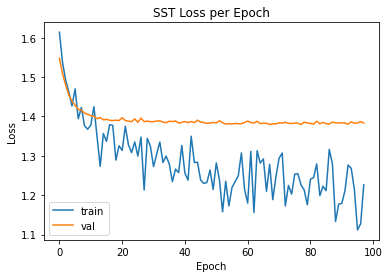

In [59]:
plot_loss(train_losses, val_losses)

In [60]:
test_loss = evaluate(model, test_dataset, test_dataset.labels(), accuracy)
print(test_loss)

0.3986425339366516


In [0]:
embed_size = 200
hidden_size = 50  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 500
lr = 0.0001
batch_size=50

model = GCNTreebankModel(embed_size, hidden_size, 5, dropout=dropout)

In [0]:
%time train_losses, val_losses = train(model, train_dataset, dev_dataset, early_stop_threshold=10, batch_size=batch_size, epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='sst_train_50.pt')

Epoch 0
Train mean cross-entropy: 3.3519557700875926
Validation mean cross-entropy: 1.9822099208831787
Epoch 10
Train mean cross-entropy: 1.5599214972818598
Validation mean cross-entropy: 1.4832266569137573
Epoch 20
Train mean cross-entropy: 1.352285259501899
Validation mean cross-entropy: 1.4314004182815552
Epoch 30
Train mean cross-entropy: 1.3779764724128387
Validation mean cross-entropy: 1.4169005155563354
Epoch 40
Train mean cross-entropy: 1.2802811318898901
Validation mean cross-entropy: 1.4153870344161987
Epoch 50
Train mean cross-entropy: 1.344598562226576
Validation mean cross-entropy: 1.417385220527649
CPU times: user 4min 44s, sys: 15.8 s, total: 4min 59s
Wall time: 5min 2s


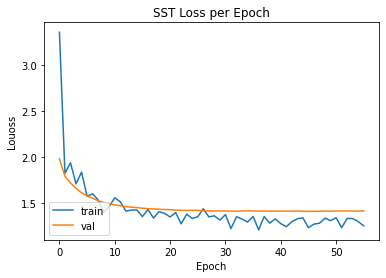

In [0]:
plot_loss(train_losses, val_losses)

In [0]:
test_loss = evaluate(model, test_dataset, test_dataset.labels(), accuracy)
print(test_loss)

0.3932126696832579


In [0]:
embed_size = 200
hidden_size = 50  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 500
lr = 0.0001
batch_size = 20

hidden_sizes = np.arange(20, 201, 10)
train_losses_tune_hidden = {}
val_losses_tune_hidden = {}
test_losses_tune_hiddden = {}  #should say accuracy not loss oops

for hidden_size in hidden_sizes:
    print('Hidden size: ', hidden_size)
    model = GCNTreebankModel(embed_size, hidden_size, 5, dropout=dropout)
    %time train_losses, val_losses = train(model, train_dataset, dev_dataset, early_stop_threshold=10, batch_size=batch_size, epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='sst_train_tune_hidden_{}.pt'.format(hidden_size))
    train_losses_tune_hidden[hidden_size] = train_losses
    val_losses_tune_hidden[hidden_size] = val_losses
    test_loss = evaluate(model, test_dataset, test_dataset.labels(), accuracy)
    print('Test loss:', test_loss)
    test_losses_tune_hiddden[hidden_size] = test_loss
    print()

Hidden size:  20
Epoch 0
Train mean cross-entropy: 2.7853284167034214
Validation mean cross-entropy: 1.9266678094863892
Epoch 10
Train mean cross-entropy: 1.4637205557814805
Validation mean cross-entropy: 1.4770458936691284
Epoch 20
Train mean cross-entropy: 1.383004100456729
Validation mean cross-entropy: 1.4301478862762451
Epoch 30
Train mean cross-entropy: 1.371755380541156
Validation mean cross-entropy: 1.4183193445205688
Epoch 40
Train mean cross-entropy: 1.3432724756958614
Validation mean cross-entropy: 1.4141267538070679
Epoch 50
Train mean cross-entropy: 1.3647704778775678
Validation mean cross-entropy: 1.4104743003845215
Epoch 60
Train mean cross-entropy: 1.3488317168900084
Validation mean cross-entropy: 1.4074233770370483
CPU times: user 5min 35s, sys: 21.2 s, total: 5min 56s
Wall time: 5min 57s
Test loss: 0.38506787330316744
Hidden size:  30
Epoch 0
Train mean cross-entropy: 2.157320824026433
Validation mean cross-entropy: 1.7142874002456665
Epoch 10
Train mean cross-entropy

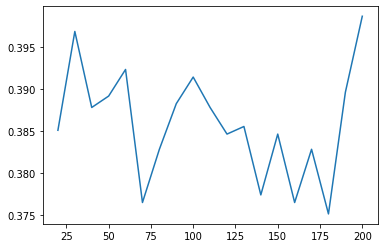

In [0]:
plt.plot(hidden_sizes, list(test_losses_tune_hiddden.values()))
plt.show()

In [0]:
print(list(size for size, loss in test_losses_tune_hiddden.items() if loss == max(test_losses_tune_hiddden.values())))

[200]


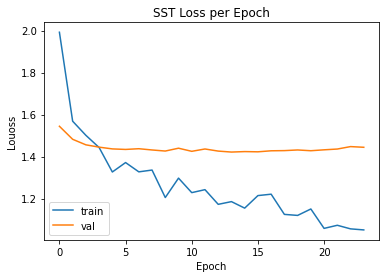

In [0]:
plot_loss(train_losses_tune_hidden[200], val_losses_tune_hidden[200])

In [0]:
test_loss = evaluate(model, test_dataset, test_dataset.labels(), accuracy)
print(test_loss)

0.3945701357466063


In [0]:
print(train_losses_tune_hidden)
print(val_losses_tune_hidden)
print(test_losses_tune_hiddden)

{20: [2.7853284167034214, 1.8755090436800024, 1.7216571624580534, 1.6361202259113974, 1.5998569654706492, 1.5787097517514397, 1.5280431891492714, 1.5101955496734423, 1.5438745957068594, 1.489485154107248, 1.4637205557814805, 1.483938338326626, 1.471709226905881, 1.4493892573221505, 1.4522766089830241, 1.4023407198994724, 1.4012941718101501, 1.4400736543696715, 1.3862364562250133, 1.3929846907946208, 1.383004100456729, 1.4388146962298722, 1.3744081911353931, 1.3971950719242074, 1.3638950972981418, 1.3656442397790993, 1.3584759714173489, 1.3583178668865274, 1.3723073457422246, 1.3431344441109854, 1.371755380541156, 1.3427507249197859, 1.3815719761669776, 1.2958117991476483, 1.3395886260675882, 1.3753355047741875, 1.3392882648968865, 1.292591640389845, 1.3873448215721642, 1.384877465578097, 1.3432724756958614, 1.3570190737551773, 1.3227552600222394, 1.334928070214649, 1.3696016845853882, 1.3458625577756615, 1.2752546543469194, 1.3489152911605544, 1.2911510317470765, 1.3019249942110072, 1.

In [0]:
embed_size = 200
dropout = 0.5  # hyperparameter
epochs = 500
lr = 0.0001
batch_size = 20

hidden_sizes = [30, 50, 200]
init_lrs = np.arange(0.00005, 0.00051, 0.00005)
train_losses_tune_hidden_lr = {}
val_losses_tune_hidden_lr = {}
test_acc_tune_hiddden_lr = {}  #should say accuracy not loss oops

for hidden_size in hidden_sizes:
  for lr in init_lrs:
    print('Hidden size: %s and Init LR: %s' % (hidden_size, lr))
    model = GCNTreebankModel(embed_size, hidden_size, 5, dropout=dropout)
    %time train_losses, val_losses = train(model, train_dataset, dev_dataset, early_stop_threshold=10, batch_size=batch_size, epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='sst_train_tune_hidden_{}_lr_{}.pt'.format(hidden_size, lr))
    train_losses_tune_hidden_lr[(hidden_size, lr)] = train_losses
    val_losses_tune_hidden_lr[(hidden_size, lr)] = val_losses
    test_acc = evaluate(model, test_dataset, test_dataset.labels(), accuracy)
    print('Test accuracy:', test_acc)
    test_acc_tune_hiddden_lr[(hidden_size, lr)] = test_acc
    print()

Hidden size: 30 and Init LR: 5e-05
Epoch 0
Train mean cross-entropy: 2.0728748809432815
Validation mean cross-entropy: 1.8460938930511475
Epoch 10
Train mean cross-entropy: 1.5030415665000607
Validation mean cross-entropy: 1.517662763595581
Epoch 20
Train mean cross-entropy: 1.3942466221871923
Validation mean cross-entropy: 1.4624624252319336
Epoch 30
Train mean cross-entropy: 1.3930812506157844
Validation mean cross-entropy: 1.4443161487579346
Epoch 40
Train mean cross-entropy: 1.3578698249834762
Validation mean cross-entropy: 1.4343782663345337
Epoch 50
Train mean cross-entropy: 1.3568967161329346
Validation mean cross-entropy: 1.4302105903625488
Epoch 60
Train mean cross-entropy: 1.2815913685730524
Validation mean cross-entropy: 1.4290518760681152
Epoch 70
Train mean cross-entropy: 1.3232863636674312
Validation mean cross-entropy: 1.4284660816192627
CPU times: user 6min 35s, sys: 23.3 s, total: 6min 58s
Wall time: 7min
Test accuracy: 0.40135746606334843

Hidden size: 30 and Init LR:

In [0]:
print(list((params, loss) for params, loss in test_acc_tune_hiddden_lr.items() if loss == max(test_acc_tune_hiddden_lr.values())))

[((30, 0.00015000000000000001), 0.40588235294117647)]


In [0]:
embed_size = 200
hidden_size = 30  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 500
lr = 0.00015
batch_size = 50

model = GCNTreebankModel(embed_size, hidden_size, 5, dropout=dropout)

In [7]:
%time train_losses, val_losses = train(model, train_dataset, dev_dataset, early_stop_threshold=20, batch_size=batch_size, epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='sst_train.pt')

Epoch 0
Train mean cross-entropy: 2.827798097799806
Validation mean cross-entropy: 1.9121617078781128
Epoch 10
Train mean cross-entropy: 1.4781470959677416
Validation mean cross-entropy: 1.4757030010223389
Epoch 20
Train mean cross-entropy: 1.4245531792149824
Validation mean cross-entropy: 1.429850697517395
Epoch 30
Train mean cross-entropy: 1.264533607749378
Validation mean cross-entropy: 1.4190433025360107
Epoch 40
Train mean cross-entropy: 1.3119962747044422
Validation mean cross-entropy: 1.4135888814926147
Epoch 50
Train mean cross-entropy: 1.3304715679410626
Validation mean cross-entropy: 1.4126307964324951
Epoch 60
Train mean cross-entropy: 1.2669360220432282
Validation mean cross-entropy: 1.4127949476242065
Epoch 70
Train mean cross-entropy: 1.1991656030802165
Validation mean cross-entropy: 1.415101170539856
CPU times: user 5min 53s, sys: 24.6 s, total: 6min 17s
Wall time: 6min 18s


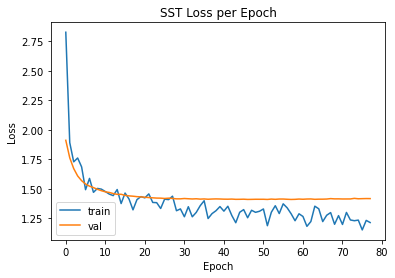

In [8]:
plot_loss(train_losses, val_losses)

In [9]:
test_loss = evaluate(model, test_dataset, test_dataset.labels(), accuracy)
print(test_loss)

0.39547511312217193


# More Layers?

In [0]:
import math
import torch
import torch.nn as nn

from src.models.gcn import GraphConv

class GCNBigTreebankModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.):
        super(GCNBigTreebankModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.softmax = nn.LogSoftmax(dim=-1)

        self.layer1 = GraphConv(input_size, hidden_size)
        self.act_func1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.layer2 = GraphConv(hidden_size, hidden_size)
        self.act_func2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.layer3 = GraphConv(hidden_size, hidden_size)
        self.act_func3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)
        self.layer4 = GraphConv(hidden_size, output_size)

    
    def forward(self, adj_matrix, inp=None):
        out = self.act_func1(self.layer1(adj_matrix, inp))
        out = self.dropout1(out)
        out = self.act_func2(self.layer2(adj_matrix, out))
        out = self.dropout2(out)
        out = self.act_func3(self.layer3(adj_matrix, out))
        out = self.dropout3(out)
        out = self.layer4(adj_matrix, out)
        out = torch.mean(out, dim=0, keepdim=True)
        
        if not self.training:
            out = self.softmax(out)
        
        return out

In [0]:
embed_size = 200
hidden_size = 30  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 500
lr = 0.00015
batch_size = 50

model = GCNBigTreebankModel(embed_size, hidden_size, 5, dropout=dropout)

In [16]:
%time train_losses, val_losses = train(model, train_dataset, dev_dataset, early_stop_threshold=10, batch_size=batch_size, epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='gcn_sst_big.pt')

Epoch 0
Train mean cross-entropy: 2.0308120704639485
Validation mean cross-entropy: 1.6605987548828125
Epoch 10
Train mean cross-entropy: 1.5221144511419185
Validation mean cross-entropy: 1.4652167558670044
Epoch 20
Train mean cross-entropy: 1.3780623686664244
Validation mean cross-entropy: 1.421675682067871
Epoch 30
Train mean cross-entropy: 1.3908399924635888
Validation mean cross-entropy: 1.4095476865768433
Epoch 40
Train mean cross-entropy: 1.3376906466834686
Validation mean cross-entropy: 1.4045599699020386
Epoch 50
Train mean cross-entropy: 1.2712829626658384
Validation mean cross-entropy: 1.399584412574768
Epoch 60
Train mean cross-entropy: 1.181836773455143
Validation mean cross-entropy: 1.4039925336837769
CPU times: user 7min 1s, sys: 19.4 s, total: 7min 20s
Wall time: 7min 25s


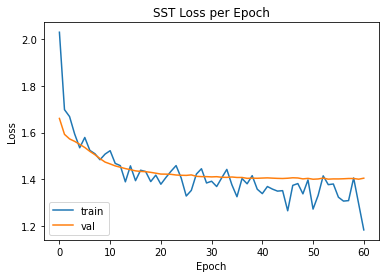

In [17]:
plot_loss(train_losses, val_losses)

In [18]:
test_loss = evaluate(model, test_dataset, test_dataset.labels(), accuracy)
print(test_loss)

0.3941176470588235
